In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


In [2]:
def rbf_kernel_3d(coords1, coords2, length_scale=0.1, sigma=1.0):
    """
    RBF (squared exponential) kernel for 3D coordinates (x,y,t).

    Parameters:
    -----------
    coords1 : array of shape (N, 3)
    coords2 : array of shape (M, 3)
    length_scale : float
        RBF length scale (assumed isotropic in 3D)
    sigma : float
        Overall variance scale

    Returns:
    --------
    K : array of shape (N, M)
        Covariance matrix between points in coords1 and coords2.
    """
    diff = coords1[:, None, :] - coords2[None, :, :]  # shape (N, M, 3)
    sqdist = np.sum(diff**2, axis=-1)                 # shape (N, M)
    K = sigma**2 * np.exp(-0.5 * sqdist / length_scale**2)
    return K


In [3]:
def generate_gp_spatio_temporal(nx=30, ny=30, nt=10,
                                length_scale=0.1, sigma=1.0,
                                random_state=None):
    """
    Generate a single sample from a 2D spatial (x,y) + 1D time (t) Gaussian Process.
    Domain: x in [0,1], y in [0,1], t in [0,1].

    Parameters:
    -----------
    nx, ny, nt : int
        Number of grid points in x, y, and t directions.
    length_scale : float
        RBF kernel length scale (isotropic for x,y,t).
    sigma : float
        Overall variance scale for the GP.
    random_state : int or None
        Random seed for reproducibility.

    Returns:
    --------
    X : array of shape (nx,)
    Y : array of shape (ny,)
    T : array of shape (nt,)
    F : array of shape (nx, ny, nt)
        Realization of the GP at each point (x_i, y_j, t_k).
    """
    if random_state is not None:
        np.random.seed(random_state)

    # 1. Define coordinate arrays
    X = np.linspace(0, 1, nx)
    Y = np.linspace(0, 1, ny)
    T = np.linspace(0, 1, nt)

    # Create a 3D mesh
    #   Xv, Yv, Tv will each have shape (nx, ny, nt)
    Xv, Yv, Tv = np.meshgrid(X, Y, T, indexing='ij')  # 'ij' keeps order (x,y,t)

    # Flatten to get (N, 3) coordinates
    coords = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))  # shape=(nx*ny*nt, 3)
    N = coords.shape[0]

    # 2. Covariance matrix
    K = rbf_kernel_3d(coords, coords, length_scale=length_scale, sigma=sigma)

    # 3. Sample from MVN
    F_vec = np.random.multivariate_normal(mean=np.zeros(N), cov=K)

    # 4. Reshape back to (nx, ny, nt)
    F = F_vec.reshape((nx, ny, nt))

    return X, Y, T, F

# Example usage:
if __name__ == "__main__":
    X, Y, T, F_true = generate_gp_spatio_temporal(
        nx=20, ny=20, nt=5, length_scale=0.2, sigma=1.0, random_state=42
    )
    print("Generated F_true shape:", F_true.shape)  # (20, 20, 5)


Generated F_true shape: (20, 20, 5)


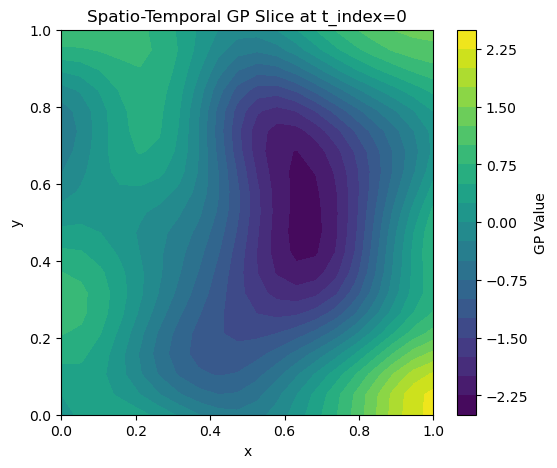

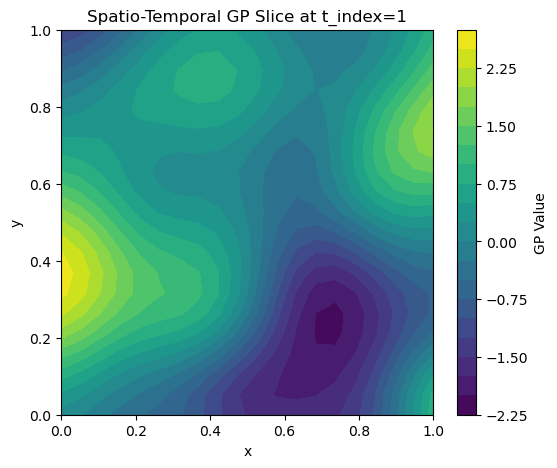

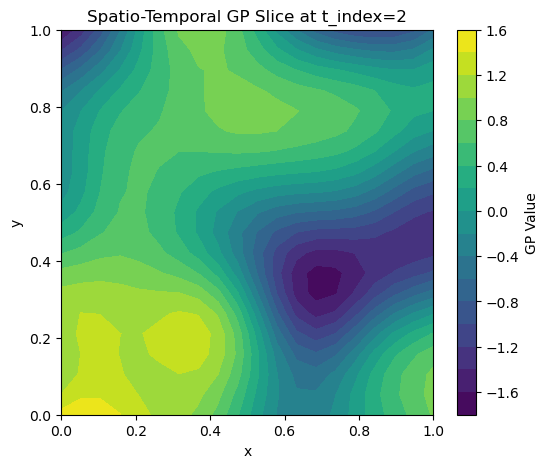

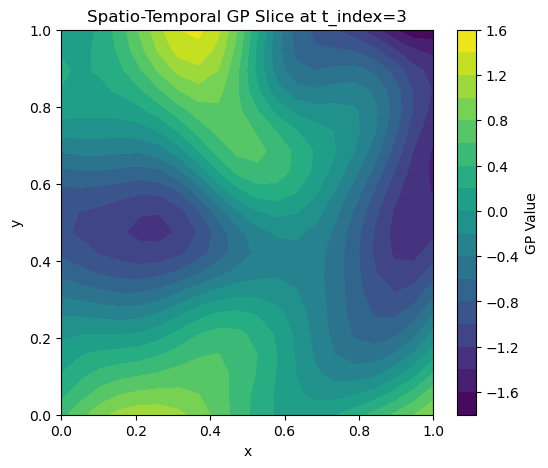

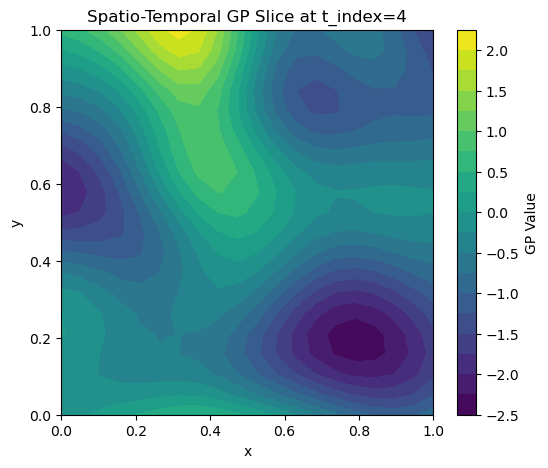

In [9]:
def plot_spatial_slice(X, Y, F, time_index=0):
    """
    Plot a 2D spatial slice of F at the given time index.
    F has shape (nx, ny, nt).
    """
    plt.figure(figsize=(6,5))
    plt.contourf(X, Y, F[:,:,time_index], levels=20, cmap='viridis')
    plt.colorbar(label="GP Value")
    plt.title(f"Spatio-Temporal GP Slice at t_index={time_index}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

if __name__ == "__main__":
    X, Y, T, F_true = generate_gp_spatio_temporal(
        nx=20, ny=20, nt=5, length_scale=0.2, sigma=1.0, random_state=42
    )

    #plt.subplot(3,2,1)
    plot_spatial_slice(X, Y, F_true, time_index=0)
    #plt.subplot(3,2,2)
    plot_spatial_slice(X, Y, F_true, time_index=1)
    #plt.subplot(3,2,3)
    plot_spatial_slice(X, Y, F_true, time_index=2)
    #plt.subplot(3,2,4)
    plot_spatial_slice(X, Y, F_true, time_index=3)
    #plt.subplot(3,2,5)
    plot_spatial_slice(X, Y, F_true, time_index=4)
    #plt.show()


In [10]:
def add_noise_spatio_temporal(F_true, noise_std=0.1):
    """
    Add i.i.d. Gaussian noise to the entire 3D field.
    """
    noise = np.random.normal(0, noise_std, size=F_true.shape)
    return F_true + noise

def scale_amplitude_spatio_temporal(F_true, scale_factor=1.1):
    """
    Scale the entire 3D field by a constant factor.
    """
    return scale_factor * F_true

def time_shift_spatio_temporal(X, Y, T, F_true, shift=0.1):
    """
    Shift the data along the time dimension by 'shift'.
    We'll do interpolation in 3D, but keep (x,y) the same, only time changes.

    Parameters:
    -----------
    X, Y, T : 1D arrays for x, y, t
    F_true  : shape (nx, ny, nt)
    shift   : how much to shift in the t dimension (positive or negative)

    Returns:
    --------
    F_shift : shape (nx, ny, nt), interpolated
    """
    # Create an interpolator over the 3D domain (x,y,t).
    #  F_interp((x_i, y_j, t_k)) = F_true[x_i, y_j, t_k]
    # We need RegularGridInterpolator with (X, Y, T).
    # But first we must ensure X, Y, T are sorted and we pass them in ascending order.
    
    F_interp = RegularGridInterpolator((X, Y, T), F_true, method='linear', bounds_error=False, fill_value=None)

    nx, ny, nt = F_true.shape
    # Create the new time array T' = T - shift
    T_shifted = T - shift
    
    # We'll build a mesh for the new coordinates
    Xv, Yv, Tv = np.meshgrid(X, Y, T_shifted, indexing='ij')
    
    # Flatten and then interpolate
    coords_new = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))
    F_shifted_flat = F_interp(coords_new)  # shape (nx*ny*nt,)
    
    # Reshape
    F_shifted = F_shifted_flat.reshape((nx, ny, nt))
    return F_shifted

def space_shift_spatio_temporal(X, Y, T, F_true, shift_x=0.05, shift_y=0.05):
    """
    Shift the data in (x,y) domain by (shift_x, shift_y),
    keeping t dimension the same. Interpolate in 2D+time.

    Returns:
    --------
    F_shift : shape (nx, ny, nt)
    """
    # Interpolate in 3D again
    F_interp = RegularGridInterpolator((X, Y, T), F_true, method='linear', bounds_error=False, fill_value=None)

    nx, ny, nt = F_true.shape
    X_shifted = X - shift_x
    Y_shifted = Y - shift_y

    Xv, Yv, Tv = np.meshgrid(X_shifted, Y_shifted, T, indexing='ij')
    coords_new = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))
    F_shifted_flat = F_interp(coords_new)
    F_shifted = F_shifted_flat.reshape((nx, ny, nt))
    return F_shifted

def correlated_noise_spatio_temporal(X, Y, T, F_true,
                                     noise_length_scale=0.05, noise_sigma=0.2):
    """
    Add noise drawn from a smaller-scale spatio-temporal GP to the original F_true.
    """
    # Make a new spatio-temporal mesh
    nx, ny, nt = F_true.shape
    Xv, Yv, Tv = np.meshgrid(X, Y, T, indexing='ij')
    coords = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))

    # Covariance for noise
    K_noise = rbf_kernel_3d(coords, coords,
                            length_scale=noise_length_scale,
                            sigma=noise_sigma)
    noise_vec = np.random.multivariate_normal(mean=np.zeros(len(coords)), cov=K_noise)
    noise_field = noise_vec.reshape(F_true.shape)

    return F_true + noise_field


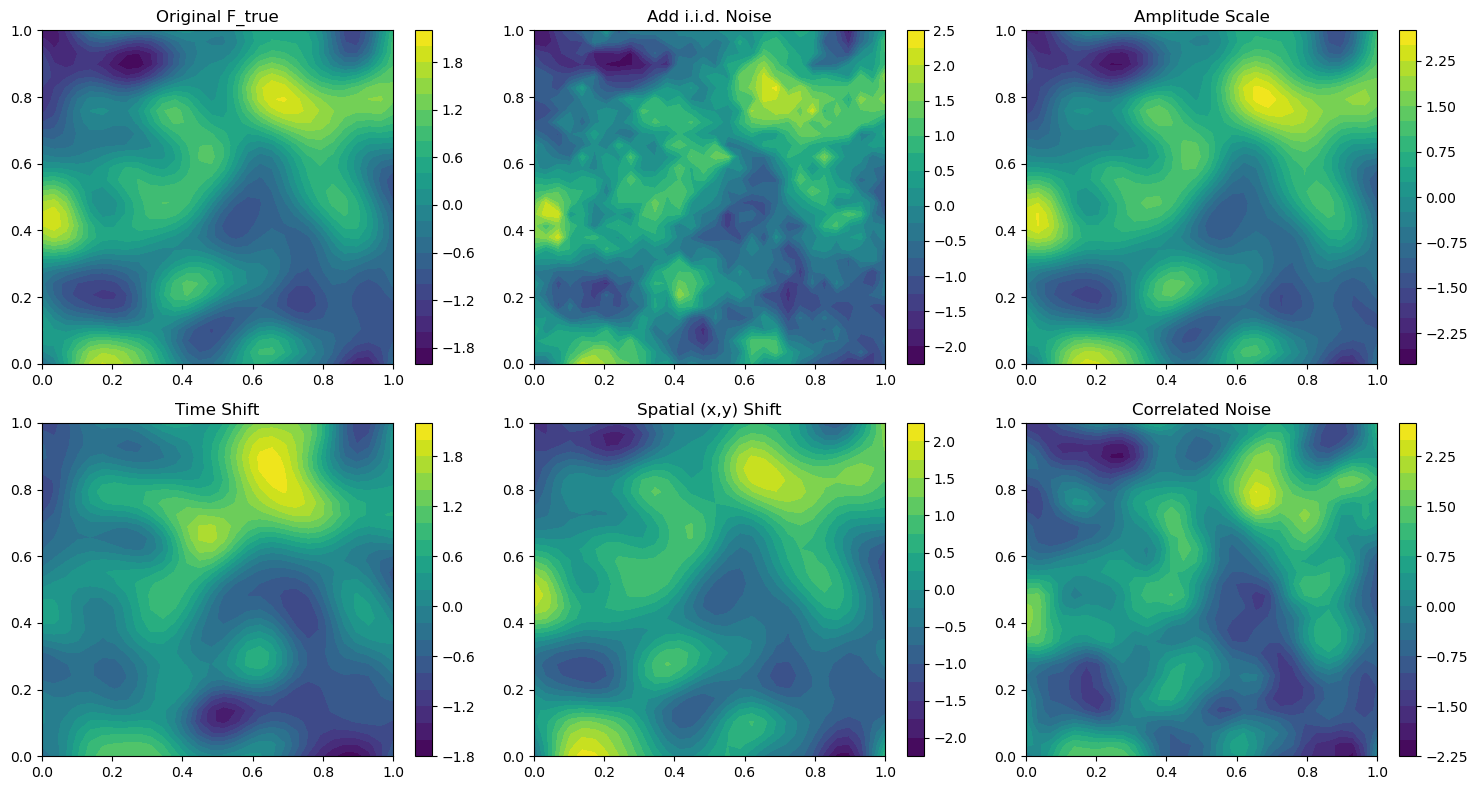

In [11]:
if __name__ == "__main__":
    # 1. Generate base spatio-temporal GP
    X, Y, T, F_true = generate_gp_spatio_temporal(nx=30, ny=30, nt=5,
                                                  length_scale=0.1, sigma=1.0,
                                                  random_state=0)
    # 2. Create perturbations
    F_noise = add_noise_spatio_temporal(F_true, noise_std=0.3)
    F_amp   = scale_amplitude_spatio_temporal(F_true, scale_factor=1.3)
    F_tshift = time_shift_spatio_temporal(X, Y, T, F_true, shift=0.1)
    F_xyshift = space_shift_spatio_temporal(X, Y, T, F_true, shift_x=0.05, shift_y=-0.03)
    F_corr = correlated_noise_spatio_temporal(X, Y, T, F_true,
                                              noise_length_scale=0.05, noise_sigma=0.3)

    # 3. Plot a single time slice for each version
    time_index = 2  # pick a middle slice
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()

    # Original
    c0 = axs[0].contourf(X, Y, F_true[:, :, time_index], levels=20, cmap='viridis')
    axs[0].set_title("Original F_true")
    plt.colorbar(c0, ax=axs[0])

    # Noise
    c1 = axs[1].contourf(X, Y, F_noise[:, :, time_index], levels=20, cmap='viridis')
    axs[1].set_title("Add i.i.d. Noise")
    plt.colorbar(c1, ax=axs[1])

    # Amplitude scale
    c2 = axs[2].contourf(X, Y, F_amp[:, :, time_index], levels=20, cmap='viridis')
    axs[2].set_title("Amplitude Scale")
    plt.colorbar(c2, ax=axs[2])

    # Time shift
    c3 = axs[3].contourf(X, Y, F_tshift[:, :, time_index], levels=20, cmap='viridis')
    axs[3].set_title("Time Shift")
    plt.colorbar(c3, ax=axs[3])

    # XY shift
    c4 = axs[4].contourf(X, Y, F_xyshift[:, :, time_index], levels=20, cmap='viridis')
    axs[4].set_title("Spatial (x,y) Shift")
    plt.colorbar(c4, ax=axs[4])

    # Correlated noise
    c5 = axs[5].contourf(X, Y, F_corr[:, :, time_index], levels=20, cmap='viridis')
    axs[5].set_title("Correlated Noise")
    plt.colorbar(c5, ax=axs[5])

    plt.tight_layout()
    plt.show()
